# Merge_VAD Data ile Başka Bir Yaklaşım İle Modeli Deneme

Saving merge_vad.zip to merge_vad.zip


In [7]:
from google.colab import files
uploaded = files.upload()  # Dosya seçme penceresini açar
zip_path = "/content/drive/MyDrive/YZTAAlzehimer/merge_vad.zip"
import zipfile
import os

# Create output directory (use a proper folder name without .zip)
extract_path = "/content/merge_vad_data2"  # Changed from merge_vad.zip to merge_vad_data
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Files extracted:", os.listdir(extract_path))

KeyboardInterrupt: 

In [9]:
import os

for root, dirs, files in os.walk("merge_vad"):
    print(f"\n📁 Klasör: {root}")
    for d in dirs:
        print(f"📂 Alt klasör: {d}")
    for f in files:
        print(f"📄 Dosya: {f}")



📁 Klasör: merge_vad


In [11]:
import os
import librosa
import numpy as np
import pandas as pd

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rmse = librosa.feature.rms(y=y)

    features = np.concatenate([
        np.mean(mfcc, axis=1),
        np.std(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.std(chroma, axis=1),
        np.mean(zcr, axis=1),
        np.mean(rmse, axis=1)
    ])
    return features

data = []
labels = []

# 🔄 Düzgün base path
base_path = "merged_data/merge_vad"

# AD, HC, MCI klasörlerini gez
for label in ["AD", "MCI", "HC"]:
    folder_path = os.path.join(base_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            try:
                features = extract_features(file_path)
                data.append(features)
                labels.append(label)
            except Exception as e:
                print(f"Hata oluştu: {file_path} -> {e}")

X = np.array(data)
y = np.array(labels)

print(f"✅ Özellik çıkarımı tamamlandı. Toplam örnek sayısı: {len(X)}")


✅ Özellik çıkarımı tamamlandı. Toplam örnek sayısı: 123


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Etiketleri sayısal hale getirme (AD → 0, HC → 1, MCI → 2 gibi)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Eğitim/test ayırımı (80% eğitim - 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("🎓 Sınıflar:", le.classes_)
print("📊 Eğitim örnekleri:", len(X_train))
print("📊 Test örnekleri:", len(X_test))


🎓 Sınıflar: ['AD' 'HC' 'MCI']
📊 Eğitim örnekleri: 98
📊 Test örnekleri: 25



🎯 Sınıflandırma Sonuçları:

              precision    recall  f1-score   support

          AD       0.67      0.40      0.50         5
          HC       0.50      0.67      0.57         9
         MCI       0.80      0.73      0.76        11

    accuracy                           0.64        25
   macro avg       0.66      0.60      0.61        25
weighted avg       0.67      0.64      0.64        25



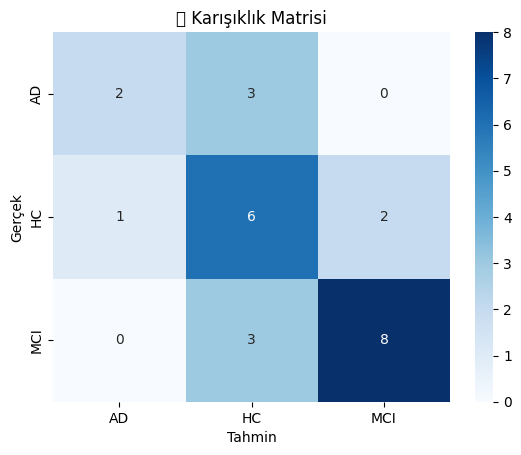

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Modeli tanımlayıp eğit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)

# Rapor
print("\n🎯 Sınıflandırma Sonuçları:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Karışıklık matrisi
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("🔍 Karışıklık Matrisi")
plt.show()


In [14]:
from collections import Counter
print(Counter(y))

Counter({np.str_('MCI'): 53, np.str_('HC'): 44, np.str_('AD'): 26})


In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("🧪 Yeni dağılım:", Counter(y_resampled))


🧪 Yeni dağılım: Counter({np.int64(0): 53, np.int64(2): 53, np.int64(1): 53})


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

          AD       0.80      0.80      0.80        10
          HC       0.60      0.55      0.57        11
         MCI       0.58      0.64      0.61        11

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.66        32
weighted avg       0.66      0.66      0.66        32



In [19]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

          AD       0.73      0.80      0.76        10
          HC       0.56      0.45      0.50        11
         MCI       0.58      0.64      0.61        11

    accuracy                           0.62        32
   macro avg       0.62      0.63      0.62        32
weighted avg       0.62      0.62      0.62        32



In [20]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
], voting='soft')  # 'soft' → olasılıklar üzerinden birleştir

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

          AD       0.73      0.80      0.76        10
          HC       0.56      0.45      0.50        11
         MCI       0.58      0.64      0.61        11

    accuracy                           0.62        32
   macro avg       0.62      0.63      0.62        32
weighted avg       0.62      0.62      0.62        32



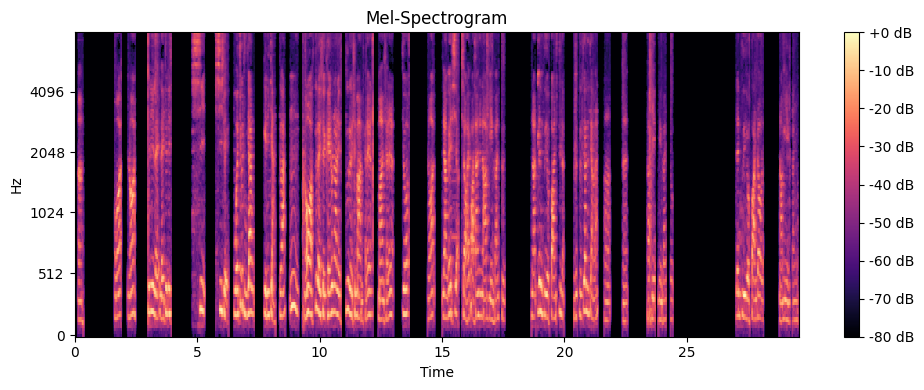

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

file_path = "merged_data/merge_vad/AD/AD_F_030807.wav"  # buraya bir örnek dosya yolu yaz
y, sr = librosa.load(file_path, sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()


In [23]:
import os
import librosa
import numpy as np

def extract_melspectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Boyutları max_len'e göre ayarla (time ekseni)
    if S_DB.shape[1] < max_len:
        pad_width = max_len - S_DB.shape[1]
        S_DB = np.pad(S_DB, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        S_DB = S_DB[:, :max_len]
    return S_DB

base_path = "merged_data/merge_vad"
X = []
y = []

for label in ["AD", "MCI", "HC"]:
    folder_path = os.path.join(base_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            try:
                mel_spec = extract_melspectrogram(file_path)
                X.append(mel_spec)
                y.append(label)
            except Exception as e:
                print(f"Hata: {file_path} -> {e}")

X = np.array(X)
y = np.array(y)

print(f"Toplam mel-spektrogram sayısı: {len(X)}")
print(f"Örnek mel-spektrogram shape: {X[0].shape}")


Toplam mel-spektrogram sayısı: 123
Örnek mel-spektrogram shape: (128, 128)


In [24]:
X = X[..., np.newaxis]  # kanal boyutu ekle
print(X.shape)  # (num_samples, 128, 128, 1)


(123, 128, 128, 1)


In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 sınıf olduğu için softmax
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 596ms/step - accuracy: 0.3927 - loss: 53.4439 - val_accuracy: 0.3600 - val_loss: 1.7867
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.4449 - loss: 2.7858 - val_accuracy: 0.3600 - val_loss: 1.1001
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.5755 - loss: 1.0779 - val_accuracy: 0.4000 - val_loss: 1.1609
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.5327 - loss: 0.9920 - val_accuracy: 0.3600 - val_loss: 4.2938
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4112 - loss: 2.3445 - val_accuracy: 0.3200 - val_loss: 1.3413
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.6966 - loss: 0.7291 - val_accuracy: 0.4800 - val_loss: 1.1903
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.7776 - loss: 0.5808 - val_accuracy: 0.4400 - val_loss: 1.2045
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.8398 - loss: 0.5105 - val_accuracy: 0.3600 - val_loss

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.3200 - val_loss: 4.6298
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - accuracy: 1.0000 - loss: 9.7200e-04 - val_accuracy: 0.3200 - val_loss: 4.6402
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 1.0000 - loss: 4.5034e-04 - val_accuracy: 0.3200 - val_loss: 4.6785
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 1.0000 - loss: 5.2352e-04 - val_accuracy: 0.3200 - val_loss: 4.7448
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.3200 - val_loss: 4.8393
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.2800 - val_loss: 4.8654


In [29]:
def extract_melspectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)

    if S_DB.shape[1] < max_len:
        pad_width = max_len - S_DB.shape[1]
        S_DB = np.pad(S_DB, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        S_DB = S_DB[:, :max_len]

    # Normalize et (0-1 arası)
    S_norm = (S_DB - S_DB.min()) / (S_DB.max() - S_DB.min())
    return S_norm


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.3200 - val_loss: 4.6881
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3200 - val_loss: 4.8065
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.3200 - val_loss: 4.8479
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step - accuracy: 1.0000 - loss: 2.0507e-04 - val_accuracy: 0.3200 - val_loss: 4.9480
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 1.0000 - loss: 4.0878e-04 - val_accuracy: 0.3200 - val_loss: 5.0295
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 1.0000 - loss: 5.7303e-04 - val_accuracy: 0.4000 - val_loss: 5.1092


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.3828 - loss: 4.8616 - val_accuracy: 0.4400 - val_loss: 6.8207
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.4237 - loss: 2.7878 - val_accuracy: 0.4400 - val_loss: 7.5004
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.4951 - loss: 1.0588 - val_accuracy: 0.4400 - val_loss: 3.5610
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.4991 - loss: 1.2019 - val_accuracy: 0.3600 - val_loss: 1.0749
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.4163 - loss: 1.0569 - val_accuracy: 0.4000 - val_loss: 1.0963
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.3853 - loss: 1.0221 - val_accuracy: 0.3600 - val_loss: 1.0916
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.3960 - loss: 1.0403 - val_accuracy: 0.3600 - val_loss: 1.0613
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.3852 - loss: 0.9748 - val_accuracy: 0.4400 - val_loss: